In [ ]:
# ==== setup: run this once per new Colab session ====

# 1) Install audio libraries (librosa is for MFCC, soundfile for reading wavs)
!pip install -q librosa soundfile

# 2) Clone the official AudioMNIST dataset from GitHub
!git clone https://github.com/soerenab/AudioMNIST.git

# 3) Check that the files are there
!ls
!ls AudioMNIST
!ls AudioMNIST/data  # one folder per speaker


Cloning into 'AudioMNIST'...
remote: Enumerating objects: 30137, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 30137 (delta 9), reused 4 (delta 1), pack-reused 30119 (from 1)
Receiving objects: 100% (30137/30137), 944.54 MiB | 22.61 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Updating files: 100% (30018/30018), done.
AudioMNIST  sample_data
data	 models		     README.md		requirements.txt
LICENSE  preprocess_data.py  recording_scripts
01  05	09  13	17  21	25  29	33  37	41  45	49  53	57  audioMNIST_meta.txt
02  06	10  14	18  22	26  30	34  38	42  46	50  54	58
03  07	11  15	19  23	27  31	35  39	43  47	51  55	59
04  08	12  16	20  24	28  32	36  40	44  48	52  56	60


In [ ]:
# basic imports
import os
import pandas as pd
import librosa
import matplotlib.pyplot as plt

# path to the dataset (inside the cloned repo)
DATA_ROOT = "/content/AudioMNIST/data"

print("Speakers (folders) :", os.listdir(DATA_ROOT)[:10])  # show a few speaker IDs


Speakers (folders) : ['31', '03', '21', '46', '15', '26', '51', '14', '57', '44']


In [ ]:
# We'll store info about each audio file in a list of dicts
#Each speaker has their own folder; each .wav filename encodes digit etc.
#Typical name format is like: 9_01_0_1_0.wav → we’ll parse the pieces.
metadata = []

for speaker_id in sorted(os.listdir(DATA_ROOT)):
    speaker_folder = os.path.join(DATA_ROOT, speaker_id)
    if not os.path.isdir(speaker_folder):
        continue

    for fname in os.listdir(speaker_folder):
        if not fname.endswith(".wav"):
            continue

        # filename pattern: digit_repetition_... .wav
        parts = fname.replace(".wav", "").split("_")
        digit = int(parts[0])          # spoken digit (0–9)
        repetition = int(parts[1])     # which repetition (1–50)

        filepath = os.path.join(speaker_folder, fname)

        metadata.append({
            "filepath": filepath,
            "speaker_id": int(speaker_id),
            "digit": digit,
            "repetition": repetition,
        })

meta_df = pd.DataFrame(metadata)
meta_df.head()


,filepath,speaker_id,digit,repetition
0,/content/AudioMNIST/data/01/8_01_34.wav,1,8,1
1,/content/AudioMNIST/data/01/6_01_40.wav,1,6,1
2,/content/AudioMNIST/data/01/1_01_49.wav,1,1,1
3,/content/AudioMNIST/data/01/9_01_10.wav,1,9,1
4,/content/AudioMNIST/data/01/3_01_38.wav,1,3,1


In [ ]:
print("Total samples :", len(meta_df))
print("Unique speakers :", meta_df['speaker_id'].nunique())
print("Digits distribution:\n", meta_df['digit'].value_counts().sort_index())


Total samples : 30000
Unique speakers : 60
Digits distribution:
 digit
0    3000
1    3000
2    3000
3    3000
4    3000
5    3000
6    3000
7    3000
8    3000
9    3000
Name: count, dtype: int64


Step2: Waveform & Spectrogram Visualizations

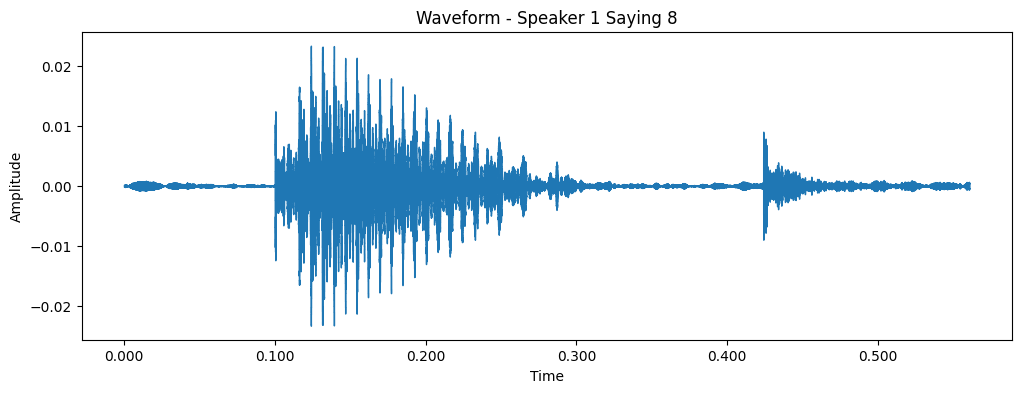

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# choose a random sample
sample_path = meta_df.iloc[0]['filepath']

# load audio
audio, sr = librosa.load(sample_path, sr=None)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title(f"Waveform - Speaker {meta_df.iloc[0]['speaker_id']} Saying {meta_df.iloc[0]['digit']}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


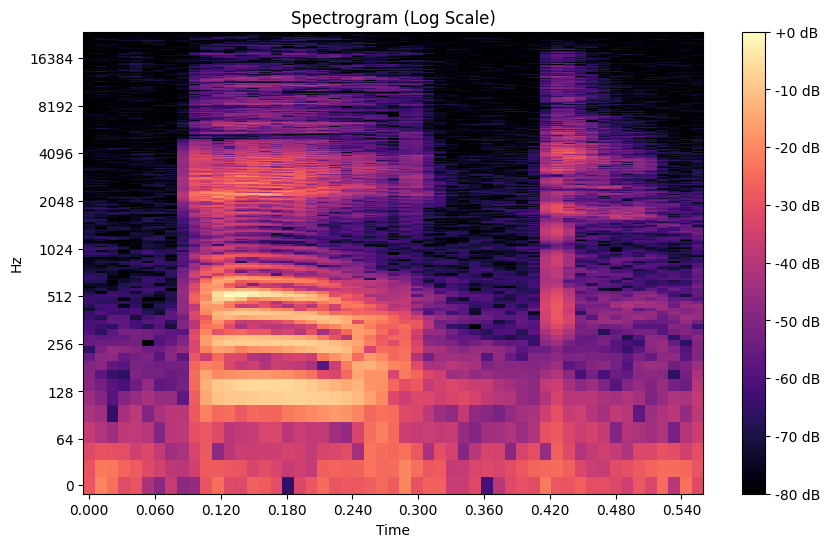

In [ ]:
import numpy as np

# compute Short-Time Fourier Transform
stft = librosa.stft(audio)
spectrogram = np.abs(stft)

plt.figure(figsize=(10, 6))
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),
                         sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (Log Scale)")
plt.show()


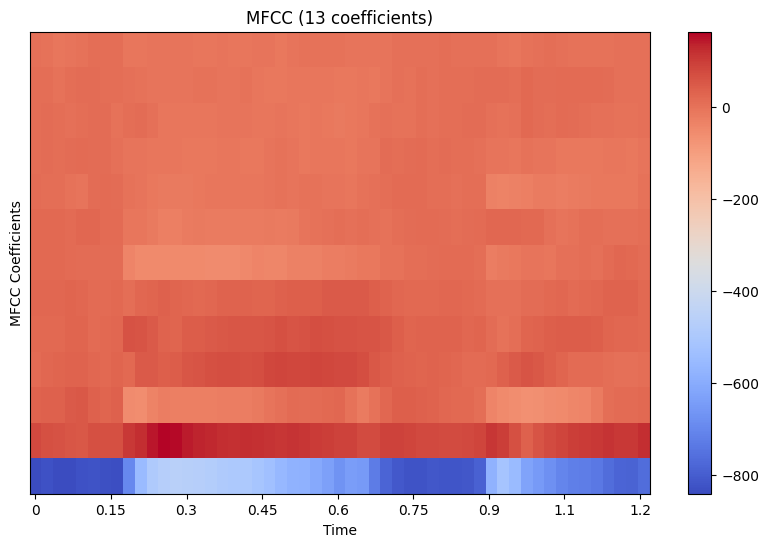

In [ ]:
# compute 13 MFCCs
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

plt.figure(figsize=(10, 6))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title("MFCC (13 coefficients)")
plt.ylabel("MFCC Coefficients")
plt.show()


In [ ]:
#Preprocessing + MFCC helper functions
import numpy as np
import librosa

# Target sampling rate for all audio
TARGET_SR = 16000

# MFCC parameters (used for BOTH ML & DL features)
N_MFCC = 20
N_FFT = 512
HOP_LENGTH = 160  # ~10 ms
WIN_LENGTH = 400  # ~25 ms

def load_and_preprocess(path, sr=TARGET_SR):
    """
    Load audio, resample to sr, trim silence, normalize amplitude.
    """
    y, sr_orig = librosa.load(path, sr=None)

    # resample if needed
    if sr_orig != sr:
        y = librosa.resample(y, orig_sr=sr_orig, target_sr=sr)

    # trim leading/trailing silence
    y, _ = librosa.effects.trim(y, top_db=25)

    # if completely silent after trim, create small dummy signal
    if len(y) == 0:
        y = np.zeros(int(0.5 * sr))

    # normalize to [-1, 1]
    max_abs = np.max(np.abs(y))
    if max_abs > 0:
        y = y / max_abs

    return y, sr


def compute_mfcc(y, sr=TARGET_SR):
    """
    Compute MFCC matrix: shape (N_MFCC, T_frames).
    """
    mfcc = librosa.feature.mfcc(
        y=y, sr=sr,
        n_mfcc=N_MFCC,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        win_length=WIN_LENGTH
    )
    return mfcc


def mfcc_to_stats(mfcc):
    """
    Convert MFCC matrix → fixed-length vector for ML models.
    Here we use mean and std of each coefficient.
    """
    mean = mfcc.mean(axis=1)   # shape (N_MFCC,)
    std = mfcc.std(axis=1)     # shape (N_MFCC,)
    return np.concatenate([mean, std], axis=0)  # length = 2 * N_MFCC


In [ ]:
#Loop over all files and compute MFCCs
# Lists to store intermediate results
mfcc_list = []      # full MFCC matrices (for DL)
stats_list = []     # MFCC stats (for ML)

num_files = len(meta_df)
print("Total files:", num_files)

for idx, row in meta_df.iterrows():
    y, sr = load_and_preprocess(row["filepath"])
    mfcc = compute_mfcc(y, sr)

    mfcc_list.append(mfcc)
    stats_list.append(mfcc_to_stats(mfcc))

    # simple progress print
    if (idx + 1) % 2000 == 0 or (idx + 1) == num_files:
        print(f"Processed {idx + 1}/{num_files} files")

print("Done computing MFCCs.")


Total files: 30000
Processed 2000/30000 files
Processed 4000/30000 files
Processed 6000/30000 files
Processed 8000/30000 files
Processed 10000/30000 files
Processed 12000/30000 files
Processed 14000/30000 files
Processed 16000/30000 files
Processed 18000/30000 files
Processed 20000/30000 files
Processed 22000/30000 files
Processed 24000/30000 files
Processed 26000/30000 files
Processed 28000/30000 files
Processed 30000/30000 files
Done computing MFCCs.


In [ ]:
#Build ML & DL feature arrays
# ----- ML features: MFCC statistics -----
X_ml = np.vstack(stats_list).astype(np.float32)  # shape (N_samples, 2 * N_MFCC)

# ----- DL features: padded MFCC matrices -----
# find max time length across all samples
max_T = max(m.shape[1] for m in mfcc_list)
print("Max number of frames (T):", max_T)

# create 3D array: (N_samples, N_MFCC, max_T)
X_dl = np.zeros((len(mfcc_list), N_MFCC, max_T), dtype=np.float32)

for i, m in enumerate(mfcc_list):
    t = m.shape[1]
    X_dl[i, :, :t] = m  # pad the rest with zeros

# labels (for speaker ID task we mainly use speaker_id)
y_speaker = meta_df["speaker_id"].values.astype(np.int64)
y_digit = meta_df["digit"].values.astype(np.int64)

print("X_ml shape:", X_ml.shape)
print("X_dl shape:", X_dl.shape)
print("y_speaker shape:", y_speaker.shape)
print("y_digit shape:", y_digit.shape)


Max number of frames (T): 100
X_ml shape: (30000, 40)
X_dl shape: (30000, 20, 100)
y_speaker shape: (30000,)
y_digit shape: (30000,)


In [ ]:
import pandas as pd

# save metadata as CSV (easy to inspect)
meta_df.to_csv("audio_mnist_metadata.csv", index=False)

# save features & labels in compressed NumPy file
np.savez_compressed(
    "audio_mnist_mfcc_features.npz",
    X_ml=X_ml,
    X_dl=X_dl,
    y_speaker=y_speaker,
    y_digit=y_digit
)

# quick check: list saved files
!ls -lh audio_mnist*


-rw-r--r-- 1 root root 1.4M Dec 22 07:31 audio_mnist_metadata.csv
-rw-r--r-- 1 root root 131M Dec 22 07:31 audio_mnist_mfcc_features.npz


In [ ]:
#Create stratified train/val/test splits (by speaker)
from sklearn.model_selection import train_test_split
import numpy as np

# we'll split based on indices, but stratify on speaker labels
indices = np.arange(len(meta_df))
labels = y_speaker  # speaker ID (for speaker identification task)

# 70% train, 30% temp
train_idx, temp_idx, y_train, y_temp = train_test_split(
    indices,
    labels,
    test_size=0.30,
    random_state=42,
    stratify=labels
)

# split temp into 15% val, 15% test (so 0.5 of the temp each)
val_idx, test_idx, y_val, y_test = train_test_split(
    temp_idx,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Train size:", len(train_idx))
print("Val size  :", len(val_idx))
print("Test size :", len(test_idx))


Train size: 21000
Val size  : 4500
Test size : 4500


In [ ]:
#quick check – class balance
import pandas as pd

def count_speakers(idxs, name):
    counts = pd.Series(y_speaker[idxs]).value_counts().sort_index()
    print(f"{name} speakers:", len(counts))
    print(counts.head())

count_speakers(train_idx, "Train")
count_speakers(val_idx, "Val")
count_speakers(test_idx, "Test")


Train speakers: 60
1    350
2    350
3    350
4    350
5    350
Name: count, dtype: int64
Val speakers: 60
1    75
2    75
3    75
4    75
5    75
Name: count, dtype: int64
Test speakers: 60
1    75
2    75
3    75
4    75
5    75
Name: count, dtype: int64


In [ ]:
np.savez(
    "audio_mnist_splits_speaker_stratified.npz",
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx
)

!ls -lh audio_mnist*


-rw-r--r-- 1 root root 1.4M Dec 22 07:31 audio_mnist_metadata.csv
-rw-r--r-- 1 root root 131M Dec 22 07:31 audio_mnist_mfcc_features.npz
-rw-r--r-- 1 root root 236K Dec 22 07:31 audio_mnist_splits_speaker_stratified.npz


In [ ]:
#Helper to load data + create splits
import numpy as np

def load_audio_mnist_features():
    """
    Load precomputed MFCC features and split indices.
    Returns:
        X_ml, X_dl, y_speaker, y_digit, train_idx, val_idx, test_idx
    """
    feat = np.load("audio_mnist_mfcc_features.npz")
    splits = np.load("audio_mnist_splits_speaker_stratified.npz")

    X_ml = feat["X_ml"]          # (N, 2*N_MFCC)  -> ML features
    X_dl = feat["X_dl"]          # (N, N_MFCC, T) -> DL features
    y_speaker = feat["y_speaker"]
    y_digit = feat["y_digit"]

    train_idx = splits["train_idx"]
    val_idx = splits["val_idx"]
    test_idx = splits["test_idx"]

    return X_ml, X_dl, y_speaker, y_digit, train_idx, val_idx, test_idx


def get_ml_data():
    """
    Convenience function for classical ML models.
    Returns:
        X_train_ml, X_val_ml, X_test_ml,
        y_train_spk, y_val_spk, y_test_spk
    """
    X_ml, X_dl, y_speaker, y_digit, train_idx, val_idx, test_idx = load_audio_mnist_features()

    X_train_ml = X_ml[train_idx]
    X_val_ml   = X_ml[val_idx]
    X_test_ml  = X_ml[test_idx]

    y_train_spk = y_speaker[train_idx]
    y_val_spk   = y_speaker[val_idx]
    y_test_spk  = y_speaker[test_idx]

    return X_train_ml, X_val_ml, X_test_ml, y_train_spk, y_val_spk, y_test_spk


def get_dl_data():
    """
    Convenience function for deep learning models.
    Returns:
        X_train_dl, X_val_dl, X_test_dl,
        y_train_spk, y_val_spk, y_test_spk
    """
    X_ml, X_dl, y_speaker, y_digit, train_idx, val_idx, test_idx = load_audio_mnist_features()

    X_train_dl = X_dl[train_idx]
    X_val_dl   = X_dl[val_idx]
    X_test_dl  = X_dl[test_idx]

    y_train_spk = y_speaker[train_idx]
    y_val_spk   = y_speaker[val_idx]
    y_test_spk  = y_speaker[test_idx]

    return X_train_dl, X_val_dl, X_test_dl, y_train_spk, y_val_spk, y_test_spk


In [ ]:
X_train_ml, X_val_ml, X_test_ml, y_train_spk, y_val_spk, y_test_spk = get_ml_data()
print("ML:", X_train_ml.shape, X_val_ml.shape, X_test_ml.shape)

X_train_dl, X_val_dl, X_test_dl, y_train_spk2, y_val_spk2, y_test_spk2 = get_dl_data()
print("DL:", X_train_dl.shape, X_val_dl.shape, X_test_dl.shape)


ML: (21000, 40) (4500, 40) (4500, 40)
DL: (21000, 20, 100) (4500, 20, 100) (4500, 20, 100)


Classical ML Models

In [ ]:
#Load ML data
# Make sure helper functions from before are in the notebook
X_train_ml, X_val_ml, X_test_ml, y_train_spk, y_val_spk, y_test_spk = get_ml_data()

print("Train:", X_train_ml.shape, "Val:", X_val_ml.shape, "Test:", X_test_ml.shape)
print("Unique speakers:", len(np.unique(y_train_spk)))


Train: (21000, 40) Val: (4500, 40) Test: (4500, 40)
Unique speakers: 60


In [ ]:
#Evaluation helper (accuracy, precision, recall, F1)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(model,
                   X_train, y_train,
                   X_val, y_val,
                   X_test, y_test,
                   name="model"):
    """
    Fit model on train data and print metrics on train/val/test.
    Metrics: accuracy + macro precision/recall/F1 (multi-class).
    """
    print(f"\n===== {name} =====")
    model.fit(X_train, y_train)

    for split_name, X, y in [
        ("Train", X_train, y_train),
        ("Val",   X_val,   y_val),
        ("Test",  X_test,  y_test)
    ]:
        y_pred = model.predict(X)
        acc = accuracy_score(y, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y, y_pred, average="macro", zero_division=0
        )
        print(f"{split_name}: "
              f"Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}")


In [ ]:
#Baseline models (no hyperparameter tuning)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# 1) KNN baseline
knn5 = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=5)
)
evaluate_model(knn5,
               X_train_ml, y_train_spk,
               X_val_ml,   y_val_spk,
               X_test_ml,  y_test_spk,
               name="KNN (k=5)")


# 2) Logistic Regression baseline (multinomial softmax)
logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=1000,
        multi_class="multinomial",
        n_jobs=-1
    )
)
evaluate_model(logreg,
               X_train_ml, y_train_spk,
               X_val_ml,   y_val_spk,
               X_test_ml,  y_test_spk,
               name="Logistic Regression")


# 3) Random Forest baseline
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
evaluate_model(rf,
               X_train_ml, y_train_spk,
               X_val_ml,   y_val_spk,
               X_test_ml,  y_test_spk,
               name="Random Forest (100 trees)")



===== KNN (k=5) =====
Train: Acc=0.9931, Prec=0.9931, Rec=0.9931, F1=0.9931
Val: Acc=0.9824, Prec=0.9828, Rec=0.9824, F1=0.9823
Test: Acc=0.9867, Prec=0.9870, Rec=0.9867, F1=0.9866

===== Logistic Regression =====


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Train: Acc=0.9409, Prec=0.9408, Rec=0.9409, F1=0.9408
Val: Acc=0.9156, Prec=0.9162, Rec=0.9156, F1=0.9153
Test: Acc=0.9176, Prec=0.9184, Rec=0.9176, F1=0.9173

===== Random Forest (100 trees) =====
Train: Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000
Val: Acc=0.9673, Prec=0.9680, Rec=0.9673, F1=0.9673
Test: Acc=0.9713, Prec=0.9720, Rec=0.9713, F1=0.9713


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

SAVE_DIR = "/content/drive/MyDrive/AudioMNIST_Project/Confusion_Matrices"
os.makedirs(SAVE_DIR, exist_ok=True)

print("Saving to:", SAVE_DIR)


Saving to: /content/drive/MyDrive/AudioMNIST_Project/Confusion_Matrices


In [ ]:
#Confusion Matrix Helper (for any model)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", normalize=None):
    """
    Plot a confusion matrix.
    - normalize=None      : raw counts
    - normalize='true'    : each row sums to 1 (per-class recall)
    - normalize='pred'    : each column sums to 1
    - normalize='all'     : all entries sum to 1
    """
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap="Blues", colorbar=True)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


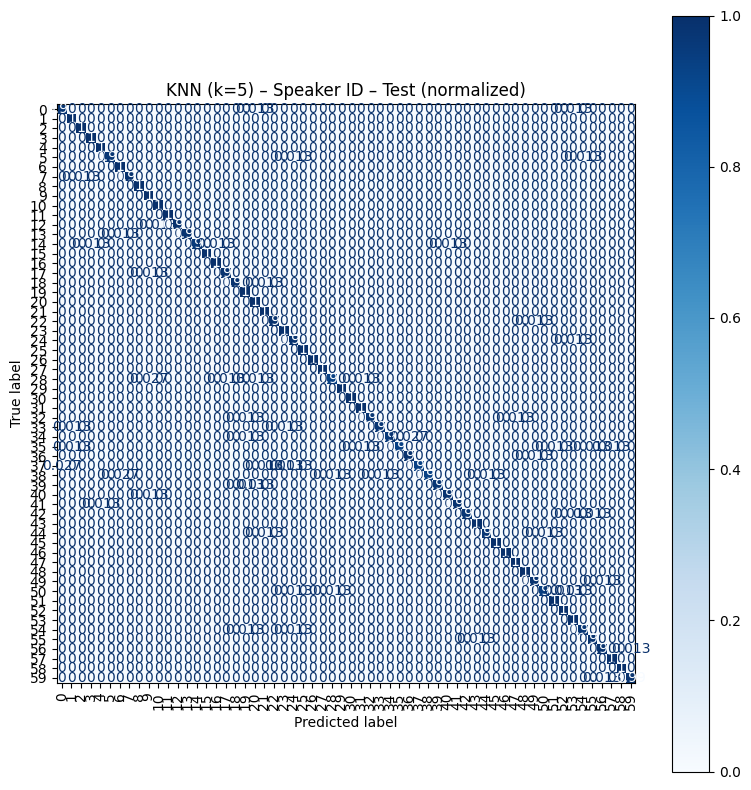

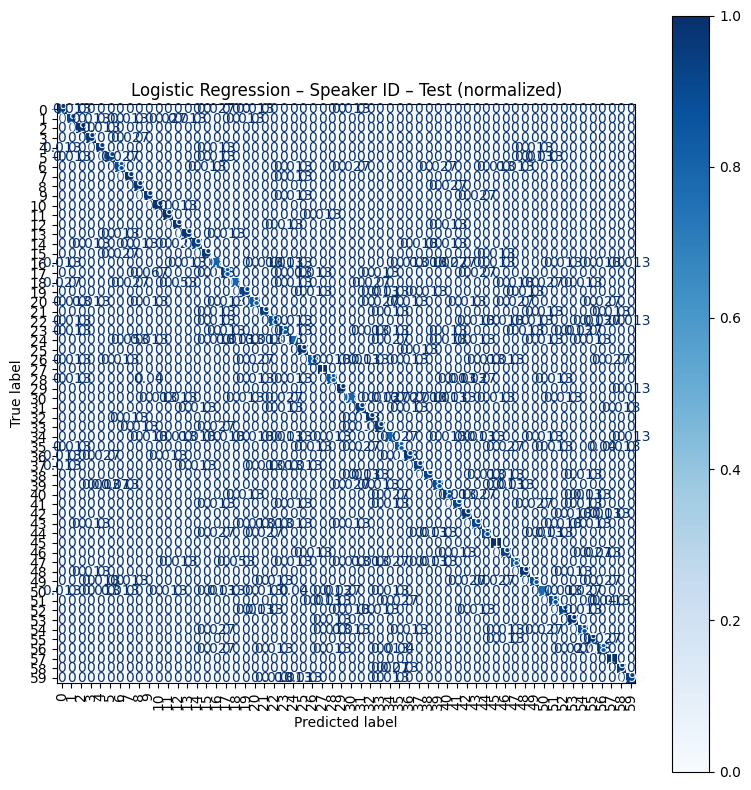

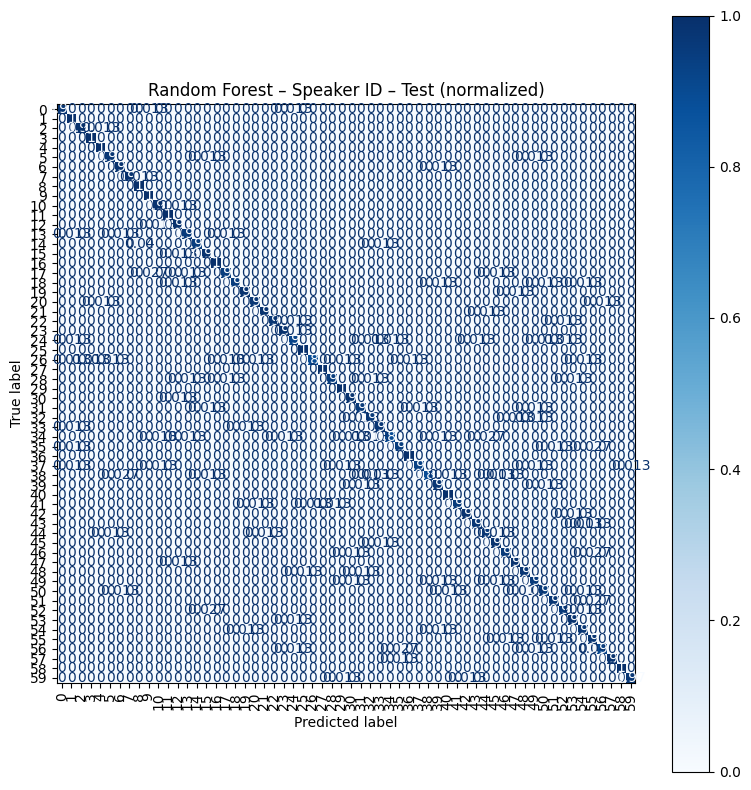

In [ ]:
# KNN (k=5)
y_pred_knn_test = knn5.predict(X_test_ml)
plot_confusion_matrix(
    y_test_spk,
    y_pred_knn_test,
    title="KNN (k=5) – Speaker ID – Test (normalized)",
    normalize="true"
)

# Logistic Regression
y_pred_logreg_test = logreg.predict(X_test_ml)
plot_confusion_matrix(
    y_test_spk,
    y_pred_logreg_test,
    title="Logistic Regression – Speaker ID – Test (normalized)",
    normalize="true"
)

# Random Forest
y_pred_rf_test = rf.predict(X_test_ml)
plot_confusion_matrix(
    y_test_spk,
    y_pred_rf_test,
    title="Random Forest – Speaker ID – Test (normalized)",
    normalize="true"
)


In [ ]:
import os

SAVE_DIR = "/content/drive/MyDrive/AudioMNIST_Project/Confusion_Matrices"
os.makedirs(SAVE_DIR, exist_ok=True)
SAVE_DIR


'/content/drive/MyDrive/AudioMNIST_Project/Confusion_Matrices'

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Save KNN
cm_knn = confusion_matrix(y_test_spk, y_pred_knn_test, normalize="true")
fig, ax = plt.subplots(figsize=(14, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp.plot(ax=ax, cmap="Blues", colorbar=True)
plt.title("KNN (k=5) – Normalized Confusion Matrix", fontsize=18)
plt.xticks([], [])
plt.yticks([], [])
fig.savefig(f"{SAVE_DIR}/KNN_Confusion.png", dpi=300, bbox_inches="tight")
plt.close()
print("Saved KNN:", f"{SAVE_DIR}/KNN_Confusion.png")

# Save Logistic Regression
cm_log = confusion_matrix(y_test_spk, y_pred_logreg_test, normalize="true")
fig, ax = plt.subplots(figsize=(14, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log)
disp.plot(ax=ax, cmap="Blues", colorbar=True)
plt.title("Logistic Regression – Normalized Confusion Matrix", fontsize=18)
plt.xticks([], [])
plt.yticks([], [])
fig.savefig(f"{SAVE_DIR}/LogReg_Confusion.png", dpi=300, bbox_inches="tight")
plt.close()
print("Saved LogReg:", f"{SAVE_DIR}/LogReg_Confusion.png")

# Save Random Forest
cm_rf = confusion_matrix(y_test_spk, y_pred_rf_test, normalize="true")
fig, ax = plt.subplots(figsize=(14, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot(ax=ax, cmap="Blues", colorbar=True)
plt.title("Random Forest – Normalized Confusion Matrix", fontsize=18)
plt.xticks([], [])
plt.yticks([], [])
fig.savefig(f"{SAVE_DIR}/RF_Confusion.png", dpi=300, bbox_inches="tight")
plt.close()
print("Saved RF:", f"{SAVE_DIR}/RF_Confusion.png")


Saved KNN: /content/drive/MyDrive/AudioMNIST_Project/Confusion_Matrices/KNN_Confusion.png
Saved LogReg: /content/drive/MyDrive/AudioMNIST_Project/Confusion_Matrices/LogReg_Confusion.png
Saved RF: /content/drive/MyDrive/AudioMNIST_Project/Confusion_Matrices/RF_Confusion.png


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp audio_mnist_metadata.csv /content/drive/MyDrive/AudioMNIST_Project/
!cp audio_mnist_mfcc_features.npz /content/drive/MyDrive/AudioMNIST_Project/
!cp audio_mnist_splits_speaker_stratified.npz /content/drive/MyDrive/AudioMNIST_Project/


In [ ]:
!ls -lh /content/drive/MyDrive/AudioMNIST_Project/


total 142M
drwx------ 2 root root 4.0K Dec 20 14:07 AudioMNIST
-rw------- 1 root root 1.4M Dec 22 07:33 audio_mnist_metadata.csv
-rw------- 1 root root 131M Dec 22 07:33 audio_mnist_mfcc_features.npz
-rw------- 1 root root 236K Dec 22 07:33 audio_mnist_splits_speaker_stratified.npz
drwx------ 2 root root 4.0K Dec 22 07:33 Confusion_Matrices
-rw------- 1 root root   94 Dec 20 15:35 final_model_comparison.csv
-rw------- 1 root root  11M Dec 20 15:14 Improved_CNN.keras


Base SVM (RBF kernel) – no tuning yet

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Base SVM model with RBF kernel
svm_base = make_pipeline(
    StandardScaler(),
    SVC(
        kernel="rbf",       # RBF kernel
        C=1.0,              # default regularization strength
        gamma="scale",      # default gamma
        decision_function_shape="ovr"  # multi-class strategy
    )
)

evaluate_model(
    svm_base,
    X_train_ml, y_train_spk,
    X_val_ml,   y_val_spk,
    X_test_ml,  y_test_spk,
    name="SVM (RBF) - Base"
)



===== SVM (RBF) - Base =====
Train: Acc=0.9990, Prec=0.9991, Rec=0.9990, F1=0.9990
Val: Acc=0.9896, Prec=0.9897, Rec=0.9896, F1=0.9896
Test: Acc=0.9909, Prec=0.9911, Rec=0.9909, F1=0.9909


Confusion matrix for SVM

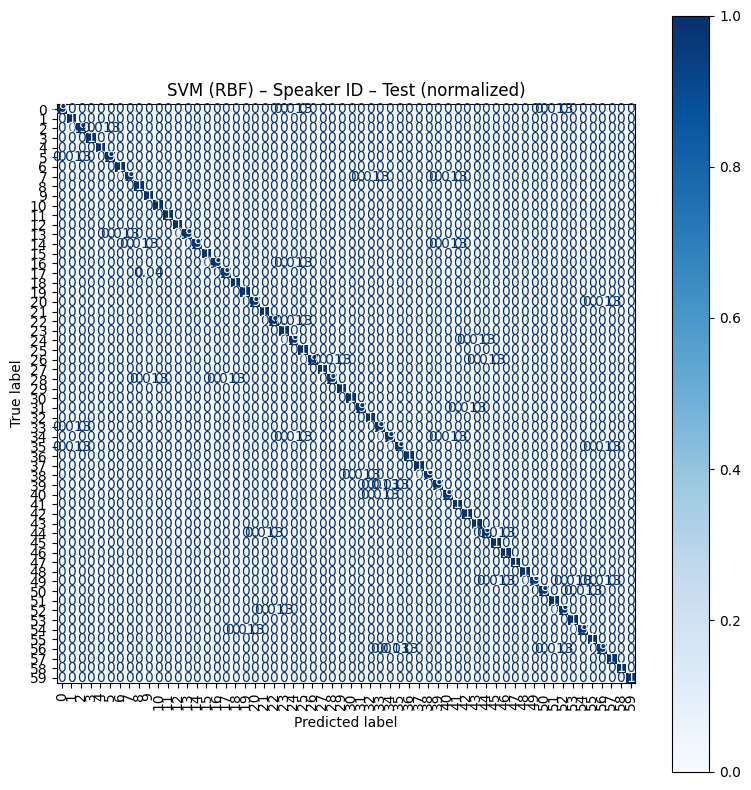

In [ ]:
# Predict on test set
y_pred_svm_test = svm_base.predict(X_test_ml)

# Reuse the same confusion matrix helper she used
plot_confusion_matrix(
    y_test_spk,
    y_pred_svm_test,
    title="SVM (RBF) – Speaker ID – Test (normalized)",
    normalize="true"
)


**SVM Hyperparameter Tuning (GridSearchCV)**

Make a smaller subset of the training data (10%)

In [ ]:
from sklearn.model_selection import train_test_split

# use only 10% of the training data for tuning (much faster)
X_small, _, y_small, _ = train_test_split(
    X_train_ml, y_train_spk,
    train_size=0.10,
    stratify=y_train_spk,
    random_state=42
)

print("Subset for tuning:", X_small.shape, "labels:", y_small.shape)


Subset for tuning: (2100, 40) labels: (2100,)


Fast SVM tuning (small grid + subset)

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Pipeline: scaler + SVM
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf"))
])

# 🔹 Smaller, faster hyperparameter grid
param_grid = {
    "svm__C": [1, 10],
    "svm__gamma": ["scale", 0.01],
}

# GridSearchCV on the SMALL subset
grid_svm = GridSearchCV(
    svm_pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    scoring="accuracy",
    verbose=1
)

grid_svm.fit(X_small, y_small)

print("Best parameters:", grid_svm.best_params_)
print("Best CV accuracy (subset):", grid_svm.best_score_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'svm__C': 10, 'svm__gamma': 'scale'}
Best CV accuracy (subset): 0.8795238095238096


Evaluate the tuned SVM on full train/val/test

In [ ]:
# best tuned SVM model
best_svm = grid_svm.best_estimator_

evaluate_model(
    best_svm,
    X_train_ml, y_train_spk,
    X_val_ml,   y_val_spk,
    X_test_ml,  y_test_spk,
    name="SVM (RBF) – Tuned (subset grid search)"
)



===== SVM (RBF) – Tuned (subset grid search) =====
Train: Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000
Val: Acc=0.9909, Prec=0.9911, Rec=0.9909, F1=0.9909
Test: Acc=0.9918, Prec=0.9919, Rec=0.9918, F1=0.9918


Confusion matrix for tuned SVM

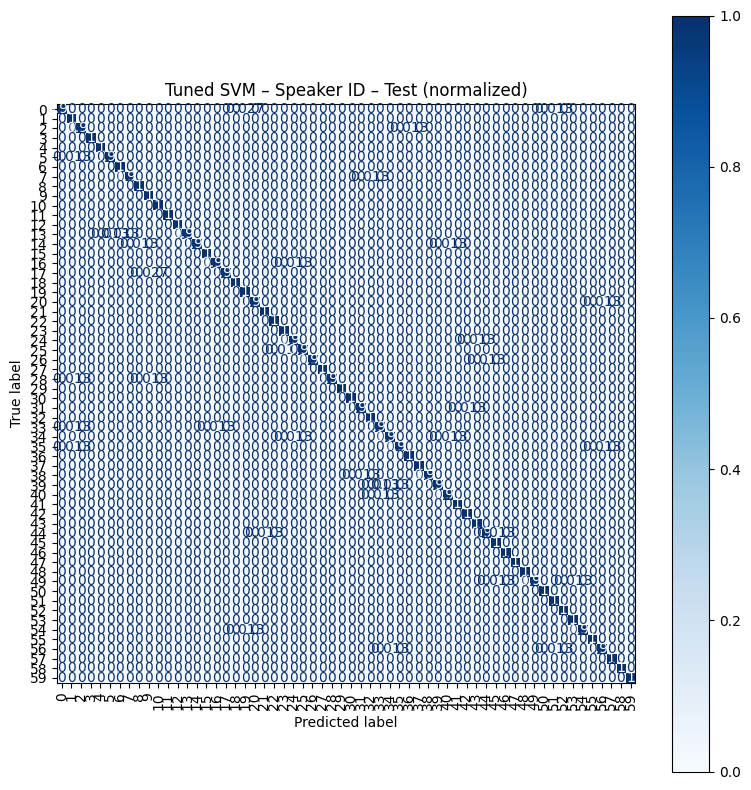

In [ ]:
y_pred_svm_tuned = best_svm.predict(X_test_ml)

plot_confusion_matrix(
    y_test_spk,
    y_pred_svm_tuned,
    title="Tuned SVM – Speaker ID – Test (normalized)",
    normalize="true"
)


Create a 10% subset for fast tuning

In [ ]:
from sklearn.model_selection import train_test_split

# Use only 10% of training data (makes tuning ~10x faster)
X_small_knn, _, y_small_knn, _ = train_test_split(
    X_train_ml, y_train_spk,
    train_size=0.10,
    stratify=y_train_spk,
    random_state=42
)

print("Subset for KNN tuning:", X_small_knn.shape)


Subset for KNN tuning: (2100, 40)


Fast KNN Hyperparameter Tuning (with comments)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# KNN pipeline = StandardScaler + KNN
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

#Small but effective hyperparameter grid
param_grid_knn = {
    "knn__n_neighbors": [3, 5, 7, 9, 11],     # try different k values
    "knn__weights": ["uniform", "distance"],  # distance weighting can improve accuracy
    "knn__metric": ["euclidean", "manhattan"] # two common distance metrics
}

# Grid search on the SMALL subset → MUCH faster
grid_knn = GridSearchCV(
    knn_pipeline,
    param_grid_knn,
    cv=3,               # 3-fold CV
    n_jobs=-1,          # use all CPU cores
    scoring="accuracy",
    verbose=1
)

print("Tuning KNN… this will finish in a few minutes.")
grid_knn.fit(X_small_knn, y_small_knn)

print("Best KNN Parameters:", grid_knn.best_params_)
print("Best CV Accuracy (subset):", grid_knn.best_score_)


Tuning KNN… this will finish in a few minutes.
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best KNN Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best CV Accuracy (subset): 0.7733333333333334


Evaluate the TUNED KNN on full train/val/test

In [ ]:
# Best-tuned KNN model
best_knn = grid_knn.best_estimator_

evaluate_model(
    best_knn,
    X_train_ml, y_train_spk,
    X_val_ml,   y_val_spk,
    X_test_ml,  y_test_spk,
    name="KNN – Tuned"
)



===== KNN – Tuned =====
Train: Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000
Val: Acc=0.9869, Prec=0.9871, Rec=0.9869, F1=0.9869
Test: Acc=0.9878, Prec=0.9880, Rec=0.9878, F1=0.9878


**TUNE RANDOM FOREST**

Create a small subset for tuning (10% of train)

In [ ]:
from sklearn.model_selection import train_test_split

# Use only 10% of training data for tuning (Random Forest is faster than SVM,
# but this still makes GridSearch much quicker)
X_small_rf, _, y_small_rf, _ = train_test_split(
    X_train_ml, y_train_spk,
    train_size=0.10,
    stratify=y_train_spk,
    random_state=42
)

print("Subset for RF tuning:", X_small_rf.shape)


Subset for RF tuning: (2100, 40)


Random Forest hyperparameter tuning (GridSearchCV)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# ---- Base RF model (no scaling needed for trees) ----
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1           # use all CPU cores
)

# ---- Smaller hyperparameter grid for faster tuning ----
# we keep only a few strong candidates
param_grid_rf = {
    "n_estimators": [150, 250],     # fewer options than before
    "max_depth": [None, 30],        # shallow vs "unlimited-ish"
    "max_features": ["sqrt"],       # common good default
    "min_samples_split": [2, 5]     # regular vs slightly more conservative
}

# ---- GridSearchCV on the SMALL subset ----
grid_rf = GridSearchCV(
    rf_base,
    param_grid_rf,
    cv=3,               # 3-fold CV
    n_jobs=-1,          # parallel
    scoring="accuracy",
    verbose=2           # more detailed progress printing
)

print("Tuning Random Forest (fast grid)…")
grid_rf.fit(X_small_rf, y_small_rf)

print("Best RF parameters:", grid_rf.best_params_)
print("Best CV accuracy (subset):", grid_rf.best_score_)


Tuning Random Forest (fast grid)…
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best RF parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 250}
Best CV accuracy (subset): 0.7847619047619047


In [ ]:
# overwrite best_rf with the tuned + trained model
best_rf = grid_rf.best_estimator_
print(best_rf)


RandomForestClassifier(n_estimators=250, n_jobs=-1, random_state=42)


In [ ]:
# best_rf is already grid_rf.best_estimator_
best_rf = grid_rf.best_estimator_   # safe to run again

# Evaluate tuned RF on full data
evaluate_model(
    best_rf,
    X_train_ml, y_train_spk,
    X_val_ml,   y_val_spk,
    X_test_ml,  y_test_spk,
    name="Random Forest – Tuned (fast grid)"
)



===== Random Forest – Tuned (fast grid) =====
Train: Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000
Val: Acc=0.9733, Prec=0.9739, Rec=0.9733, F1=0.9733
Test: Acc=0.9740, Prec=0.9746, Rec=0.9740, F1=0.9740


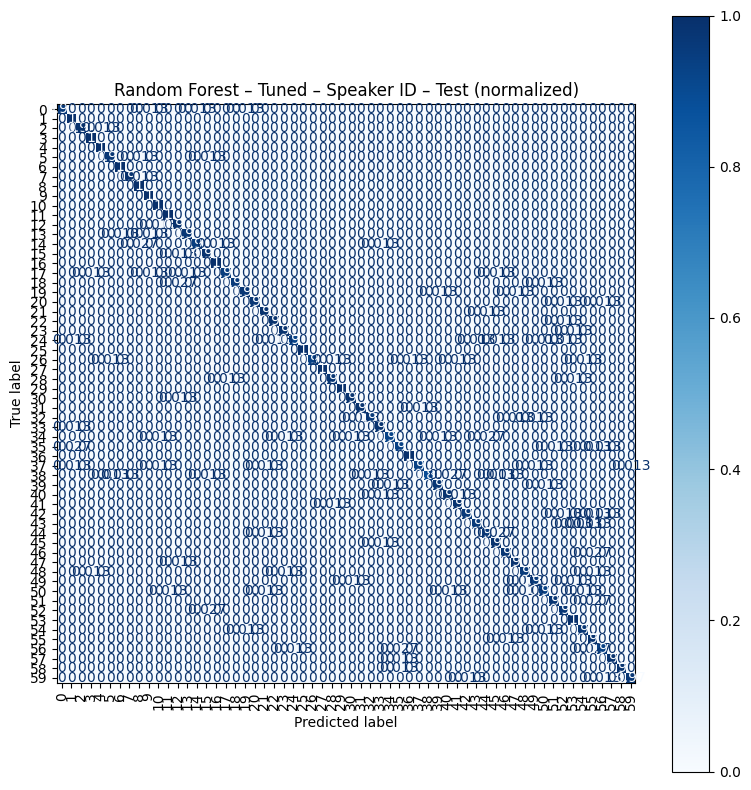

In [ ]:
y_pred_rf_tuned = best_rf.predict(X_test_ml)

plot_confusion_matrix(
    y_test_spk,
    y_pred_rf_tuned,
    title="Random Forest – Tuned – Speaker ID – Test (normalized)",
    normalize="true"
)


**Logistic Regression tuning**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Use scaler + Logistic Regression in one pipeline
logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        multi_class="multinomial"   # softmax style
    ))
])

# Small hyperparameter grid (fast but useful)
param_grid_logreg = {
    "logreg__C": [0.1, 1, 10, 100],   # regularization strength
    "logreg__penalty": ["l2"],        # standard L2 penalty
    # solver is fixed to lbfgs (default for multinomial)
}

# Optional: use only 10% of training data to tune (like SVM/KNN/RF)
from sklearn.model_selection import train_test_split

X_small_lr, _, y_small_lr, _ = train_test_split(
    X_train_ml, y_train_spk,
    train_size=0.10,
    stratify=y_train_spk,
    random_state=42
)

print("Subset for LogReg tuning:", X_small_lr.shape)

# Grid search
grid_logreg = GridSearchCV(
    logreg_pipe,
    param_grid_logreg,
    cv=3,
    n_jobs=-1,
    scoring="accuracy",
    verbose=2
)

print("Tuning Logistic Regression…")
grid_logreg.fit(X_small_lr, y_small_lr)

print("Best LogReg params:", grid_logreg.best_params_)
print("Best CV accuracy (subset):", grid_logreg.best_score_)


Subset for LogReg tuning: (2100, 40)
Tuning Logistic Regression…
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best LogReg params: {'logreg__C': 1, 'logreg__penalty': 'l2'}
Best CV accuracy (subset): 0.8057142857142857


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Evaluate tuned Logistic Regression

In [ ]:
best_logreg = grid_logreg.best_estimator_

evaluate_model(
    best_logreg,
    X_train_ml, y_train_spk,
    X_val_ml,   y_val_spk,
    X_test_ml,  y_test_spk,
    name="Logistic Regression – Tuned"
)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



===== Logistic Regression – Tuned =====
Train: Acc=0.9409, Prec=0.9408, Rec=0.9409, F1=0.9408
Val: Acc=0.9156, Prec=0.9162, Rec=0.9156, F1=0.9153
Test: Acc=0.9176, Prec=0.9184, Rec=0.9176, F1=0.9173


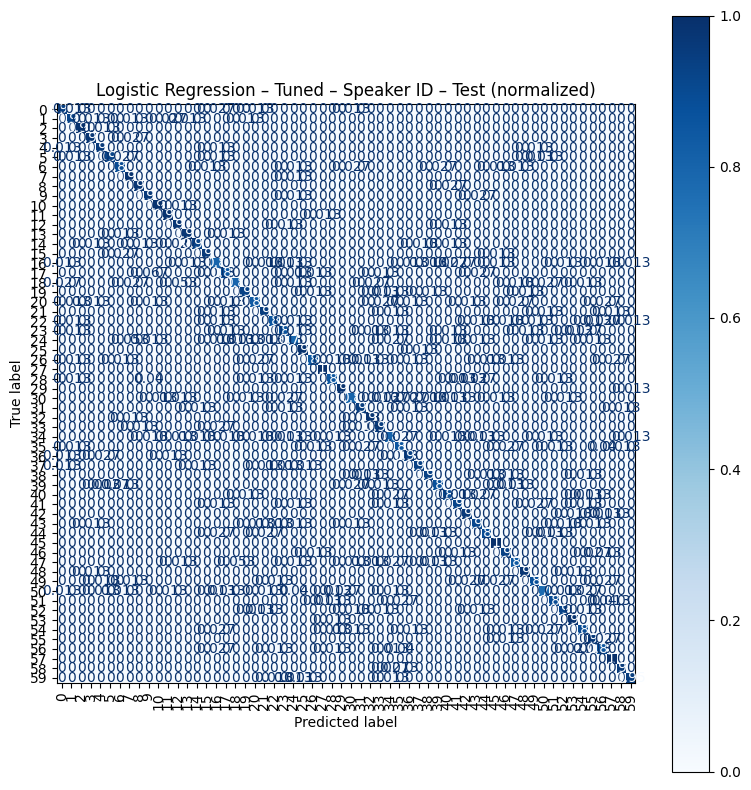

In [ ]:
y_pred_lr_tuned = best_logreg.predict(X_test_ml)

plot_confusion_matrix(
    y_test_spk,
    y_pred_lr_tuned,
    title="Logistic Regression – Tuned – Speaker ID – Test (normalized)",
    normalize="true"
)


**CNN speaker‑ID model (2D CNN on MFCC)**

Load Data

In [ ]:
import numpy as np

# Get DL MFCC features: shape (N, 20, 100)
X_train_dl, X_val_dl, X_test_dl, y_train_spk, y_val_spk, y_test_spk = get_dl_data()
print("DL shapes:", X_train_dl.shape, X_val_dl.shape, X_test_dl.shape)

# CNN expects 4D input: (batch, height, width, channels)
X_train_cnn = X_train_dl[..., np.newaxis]  # add channel dim = 1
X_val_cnn   = X_val_dl[..., np.newaxis]
X_test_cnn  = X_test_dl[..., np.newaxis]
print("CNN input shapes:", X_train_cnn.shape, X_val_cnn.shape, X_test_cnn.shape)


DL shapes: (21000, 20, 100) (4500, 20, 100) (4500, 20, 100)
CNN input shapes: (21000, 20, 100, 1) (4500, 20, 100, 1) (4500, 20, 100, 1)


Encode speaker labels to 0..(num_classes-1)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Fit label encoder on all speaker labels
le = LabelEncoder()
le.fit(np.concatenate([y_train_spk, y_val_spk, y_test_spk]))

y_train_enc = le.transform(y_train_spk)
y_val_enc   = le.transform(y_val_spk)
y_test_enc  = le.transform(y_test_spk)

num_classes = len(le.classes_)
print("Num speakers (classes):", num_classes)


Num speakers (classes): 60


Build the CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = X_train_cnn.shape[1:]  # (20, 100, 1)

model = models.Sequential([
    # Conv block 1
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    # Conv block 2
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    # Conv block 3 (optional but helps)
    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    # Flatten + dense layers
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")  # one logit per speaker
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",  # we used integer labels
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 20, 100, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 10, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 10, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 5, 25, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 5, 25, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 2, 12, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 60)             │        15,420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 894,780 (3.41 MB)

 Trainable params: 894,780 (3.41 MB)

 Non-trainable params: 0 (0.00 B)

**Train the CNN with validation and early stopping**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=3,          # stop if no improvement for 3 epochs
    restore_best_weights=True
)

history = model.fit(
    X_train_cnn, y_train_enc,
    validation_data=(X_val_cnn, y_val_enc),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)
baseline_cnn = model


Epoch 1/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7142 - loss: 0.9368 - val_accuracy: 0.8711 - val_loss: 0.4500
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7754 - loss: 0.7493 - val_accuracy: 0.9191 - val_loss: 0.2700
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8379 - loss: 0.5267 - val_accuracy: 0.9447 - val_loss: 0.1924
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8684 - loss: 0.4254 - val_accuracy: 0.9509 - val_loss: 0.1678
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8888 - loss: 0.3533 - val_accuracy: 0.9564 - val_loss: 0.1482
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9087 - loss: 0.2906 - val_accuracy: 0.9476 - val_loss: 0.1652
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9087 - loss: 0.2871 - val_accuracy: 0.9533 - val_loss: 0.1540
Epoch 8/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9134 - loss: 0.2799 - val_accuracy: 0

**Evaluate CNN on train/val/test**

In [ ]:
print("\nCNN performance:")
train_loss, train_acc = model.evaluate(X_train_cnn, y_train_enc, verbose=0)
val_loss,   val_acc   = model.evaluate(X_val_cnn,   y_val_enc,   verbose=0)
test_loss,  test_acc  = model.evaluate(X_test_cnn,  y_test_enc,  verbose=0)

print(f"Train Acc: {train_acc:.4f}")
print(f"Val   Acc: {val_acc:.4f}")
print(f"Test  Acc: {test_acc:.4f}")



CNN performance:
Train Acc: 0.9959
Val   Acc: 0.9653
Test  Acc: 0.9662


Confusion matrix for CNN

141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


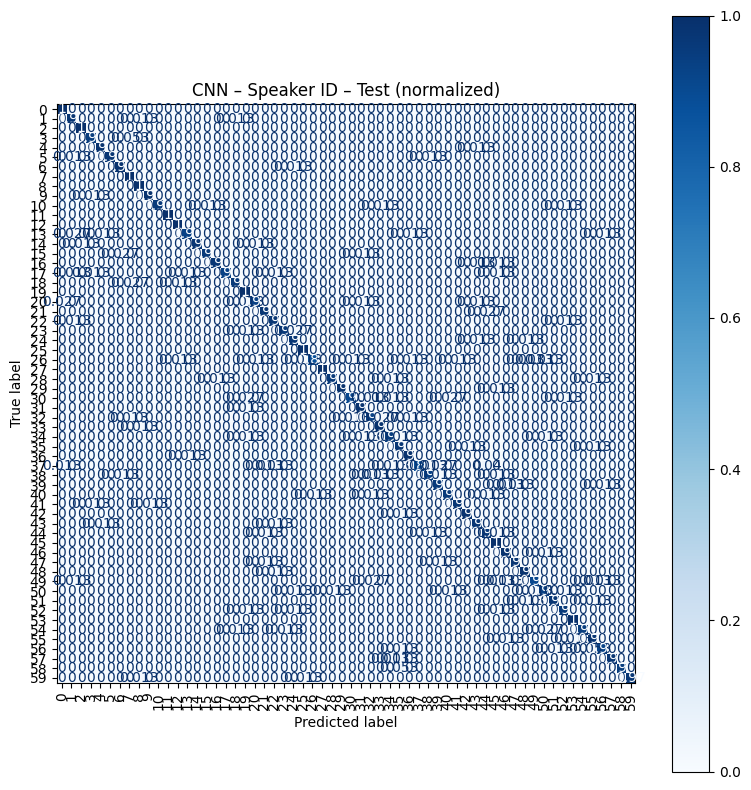

In [ ]:
# Get predicted class indices for test set
y_pred_proba = model.predict(X_test_cnn)
y_pred_cnn   = np.argmax(y_pred_proba, axis=1)

plot_confusion_matrix(
    y_test_enc,           # encoded true labels
    y_pred_cnn,
    title="CNN – Speaker ID – Test (normalized)",
    normalize="true"
)


**Comparison: CNN vs Best SVM (Speaker Identification using MFCC)**

**1. Models Compared**

**Compare CNN vs Best SVM**

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

# -------------------------------
# 1) Predict with BOTH models
# -------------------------------

# ---- SVM Predictions (on ML features) ----
svm_pred = best_svm.predict(X_test_ml)          # speaker IDs

# ---- CNN Predictions (on CNN features) ----
cnn_pred_proba = model.predict(X_test_cnn)      # shape (N, num_classes)
cnn_pred_idx   = np.argmax(cnn_pred_proba, axis=1)  # predicted class indices 0..C-1

# Convert CNN class indices back to original speaker IDs
cnn_pred = le.inverse_transform(cnn_pred_idx)   # same space as y_test_spk

# -------------------------------
# 2) Compute metrics function
# -------------------------------
def get_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return acc, prec, rec, f1

# -------------------------------
# 3) Calculate metrics
# -------------------------------
svm_acc, svm_prec, svm_rec, svm_f1 = get_metrics(y_test_spk, svm_pred)
cnn_acc, cnn_prec, cnn_rec, cnn_f1 = get_metrics(y_test_spk, cnn_pred)

# -------------------------------
# 4) Make comparison table
# -------------------------------
results_df = pd.DataFrame({
    "Model": ["Best SVM (RBF)", "CNN Model"],
    "Accuracy": [svm_acc, cnn_acc],
    "Precision": [svm_prec, cnn_prec],
    "Recall": [svm_rec, cnn_rec],
    "F1 Score": [svm_f1, cnn_f1]
})

print("\n===== CNN vs Best SVM Comparison =====\n")
print(results_df)


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

===== CNN vs Best SVM Comparison =====

            Model  Accuracy  Precision    Recall  F1 Score
0  Best SVM (RBF)  0.991778   0.991932  0.991778  0.991784
1       CNN Model  0.966222   0.967112  0.966222  0.966190


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
os.chdir("/content/drive/MyDrive/AudioMNIST_Project")

print("Current directory:", os.getcwd())
print("Files:", os.listdir())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current directory: /content/drive/MyDrive/AudioMNIST_Project
Files: ['Confusion_Matrices', 'audio_mnist_metadata.csv', 'audio_mnist_mfcc_features.npz', 'audio_mnist_splits_speaker_stratified.npz', 'AudioMNIST', 'Improved_CNN.keras', 'final_model_comparison.csv']


In [ ]:
import numpy as np

X_train_dl, X_val_dl, X_test_dl, y_train_spk, y_val_spk, y_test_spk = get_dl_data()

print("DL shapes:")
print("Train:", X_train_dl.shape)
print("Val  :", X_val_dl.shape)
print("Test :", X_test_dl.shape)


DL shapes:
Train: (21000, 20, 100)
Val  : (4500, 20, 100)
Test : (4500, 20, 100)


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(np.concatenate([y_train_spk, y_val_spk, y_test_spk]))

y_train_enc = le.transform(y_train_spk)
y_val_enc   = le.transform(y_val_spk)
y_test_enc  = le.transform(y_test_spk)

num_classes = len(le.classes_)
print("Num speakers:", num_classes)


Num speakers: 60


improved cnn

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = X_train_cnn.shape[1:]  # (20, 100, 1)

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 20, 100, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 25, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 25, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 12, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 60)             │        15,420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 894,780 (3.41 MB)

 Trainable params: 894,780 (3.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train_cnn, y_train_enc,
    validation_data=(X_val_cnn, y_val_enc),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.0195 - loss: 5.1334 - val_accuracy: 0.0442 - val_loss: 3.9495
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0621 - loss: 3.7637 - val_accuracy: 0.3064 - val_loss: 2.6532
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2872 - loss: 2.5634 - val_accuracy: 0.7191 - val_loss: 1.1152
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5421 - loss: 1.5469 - val_accuracy: 0.8320 - val_loss: 0.5990
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6855 - loss: 1.0606 - val_accuracy: 0.8549 - val_loss: 0.5035
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7691 - loss: 0.7580 - val_accuracy: 0.9169 - val_loss: 0.2849
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8265 - loss: 0.5696 - val_accuracy: 0.9367 - val_loss: 0.2159
Epoch 8/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8584 - loss: 0.4556 - val_accuracy: 0

In [ ]:
train_acc = model.evaluate(X_train_cnn, y_train_enc, verbose=0)[1]
val_acc   = model.evaluate(X_val_cnn, y_val_enc, verbose=0)[1]
test_acc  = model.evaluate(X_test_cnn, y_test_enc, verbose=0)[1]

print(f"Train Acc: {train_acc:.4f}")
print(f"Val   Acc: {val_acc:.4f}")
print(f"Test  Acc: {test_acc:.4f}")


Train Acc: 0.9965
Val   Acc: 0.9656
Test  Acc: 0.9696


Improved CNN Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

input_shape = X_train_cnn.shape[1:]  # (20, 100, 1)

improved_cnn = models.Sequential([
    # -------- Block 1 --------
    layers.Conv2D(32, (3,3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2)),

    # -------- Block 2 --------
    layers.Conv2D(64, (3,3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2)),

    # -------- Block 3 --------
    layers.Conv2D(128, (3,3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2)),

    # -------- Classifier --------
    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation="softmax")
])

improved_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

improved_cnn.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

history_improved = improved_cnn.fit(
    X_train_cnn, y_train_enc,
    validation_data=(X_val_cnn, y_val_enc),
    epochs=25,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.3185 - loss: 2.8647 - val_accuracy: 0.8329 - val_loss: 0.7111
Epoch 2/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8947 - loss: 0.4755 - val_accuracy: 0.8698 - val_loss: 0.4478
Epoch 3/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9452 - loss: 0.2332 - val_accuracy: 0.9440 - val_loss: 0.1969
Epoch 4/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9700 - loss: 0.1328 - val_accuracy: 0.9640 - val_loss: 0.1320
Epoch 5/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9699 - loss: 0.1228 - val_accuracy: 0.9642 - val_loss: 0.1370
Epoch 6/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9823 - loss: 0.0765 - val_accuracy: 0.9556 - val_loss: 0.1500
Epoch 7/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9777 - loss: 0.0864 - val_accuracy: 0.9551 - val_loss: 0.1437
Epoch 8/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9822 - loss: 0.0659 - val_accuracy: 

In [ ]:
print("\nImproved CNN Performance:")

train_acc = improved_cnn.evaluate(X_train_cnn, y_train_enc, verbose=0)[1]
val_acc   = improved_cnn.evaluate(X_val_cnn, y_val_enc, verbose=0)[1]
test_acc  = improved_cnn.evaluate(X_test_cnn, y_test_enc, verbose=0)[1]

print(f"Train Acc: {train_acc:.4f}")
print(f"Val   Acc: {val_acc:.4f}")
print(f"Test  Acc: {test_acc:.4f}")



Improved CNN Performance:
Train Acc: 0.9987
Val   Acc: 0.9851
Test  Acc: 0.9849


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


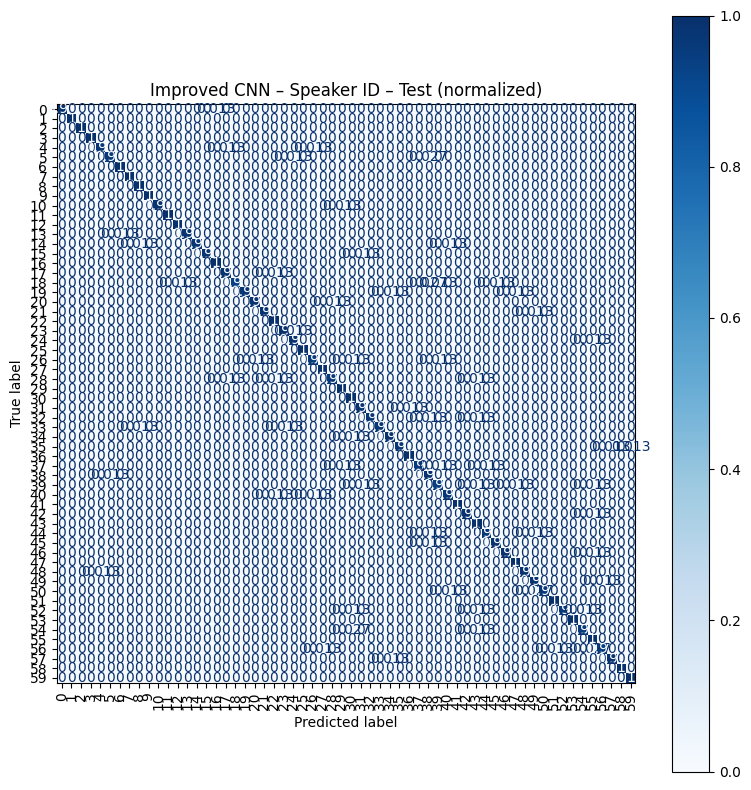

In [ ]:
y_pred_improved = np.argmax(
    improved_cnn.predict(X_test_cnn),
    axis=1
)

plot_confusion_matrix(
    y_test_enc,
    y_pred_improved,
    title="Improved CNN – Speaker ID – Test (normalized)",
    normalize="true"
)


In [ ]:
PROJECT_DIR = "/content/drive/MyDrive/AudioMNIST_Project"
import os
os.makedirs(PROJECT_DIR, exist_ok=True)
print("Saving to:", PROJECT_DIR)


Saving to: /content/drive/MyDrive/AudioMNIST_Project


In [ ]:
MODEL_PATH = f"{PROJECT_DIR}/Improved_CNN.keras"
model.save(MODEL_PATH)

print("Model saved at:", MODEL_PATH)

Model saved at: /content/drive/MyDrive/AudioMNIST_Project/Improved_CNN.keras


In [ ]:
!ls -lh /content/drive/MyDrive/AudioMNIST_Project


total 142M
drwx------ 2 root root 4.0K Dec 20 14:07 AudioMNIST
-rw------- 1 root root 1.4M Dec 22 07:33 audio_mnist_metadata.csv
-rw------- 1 root root 131M Dec 22 07:33 audio_mnist_mfcc_features.npz
-rw------- 1 root root 236K Dec 22 07:33 audio_mnist_splits_speaker_stratified.npz
drwx------ 2 root root 4.0K Dec 22 07:33 Confusion_Matrices
-rw------- 1 root root   94 Dec 20 15:35 final_model_comparison.csv
-rw------- 1 root root  11M Dec 22 07:44 Improved_CNN.keras


CNN + LSTM

In [ ]:
# ---- STATIC SHAPES (from your existing data) ----
_, n_mfcc, n_frames, _ = X_train_cnn.shape

print("MFCCs:", n_mfcc)
print("Frames:", n_frames)


MFCCs: 20
Frames: 100


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

input_shape = X_train_cnn.shape[1:]  # (20, 100, 1)

cnn_lstm = models.Sequential([

    # -------- CNN BLOCK 1 --------
    layers.Conv2D(32, (3,3), padding="same", input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2)),   # (10, 50, 32)

    # -------- CNN BLOCK 2 --------
    layers.Conv2D(64, (3,3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2)),   # (5, 25, 64)

    # -------- CNN BLOCK 3 --------
    layers.Conv2D(128, (3,3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((1,2)),   # (5, 12, 128)

    # -------- PREPARE FOR LSTM --------
    # time_steps = 12, features = 5 * 128
    layers.Reshape((12, 5 * 128)),

    # -------- LSTM --------
    layers.LSTM(128),

    # -------- CLASSIFIER --------
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation="softmax")
])

cnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_lstm.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 20, 100, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 20, 100, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 20, 100, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 10, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 10, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 10, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 10, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 5, 25, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 5, 25, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 5, 25, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 5, 25, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 5, 12, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 12, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 60)             │        15,420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,764 (2.05 MB)

 Trainable params: 535,804 (2.04 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

history_cnn_lstm = cnn_lstm.fit(
    X_train_cnn, y_train_enc,
    validation_data=(X_val_cnn, y_val_enc),
    epochs=25,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.1786 - loss: 3.2752 - val_accuracy: 0.3482 - val_loss: 2.1889
Epoch 2/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7525 - loss: 0.8934 - val_accuracy: 0.6616 - val_loss: 1.1654
Epoch 3/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8859 - loss: 0.4230 - val_accuracy: 0.7431 - val_loss: 1.0012
Epoch 4/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9316 - loss: 0.2451 - val_accuracy: 0.8609 - val_loss: 0.4463
Epoch 5/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9406 - loss: 0.2061 - val_accuracy: 0.9064 - val_loss: 0.3075
Epoch 6/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9587 - loss: 0.1442 - val_accuracy: 0.8829 - val_loss: 0.3621
Epoch 7/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9682 - loss: 0.1139 - val_accuracy: 0.8427 - val_loss: 0.5190
Epoch 8/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9752 - loss: 0.0900 - val_acc

In [ ]:
train_acc = cnn_lstm.evaluate(X_train_cnn, y_train_enc, verbose=0)[1]
val_acc   = cnn_lstm.evaluate(X_val_cnn, y_val_enc, verbose=0)[1]
test_acc  = cnn_lstm.evaluate(X_test_cnn, y_test_enc, verbose=0)[1]

print(f"Train Acc: {train_acc:.4f}")
print(f"Val   Acc: {val_acc:.4f}")
print(f"Test  Acc: {test_acc:.4f}")


Train Acc: 0.9358
Val   Acc: 0.9064
Test  Acc: 0.9038


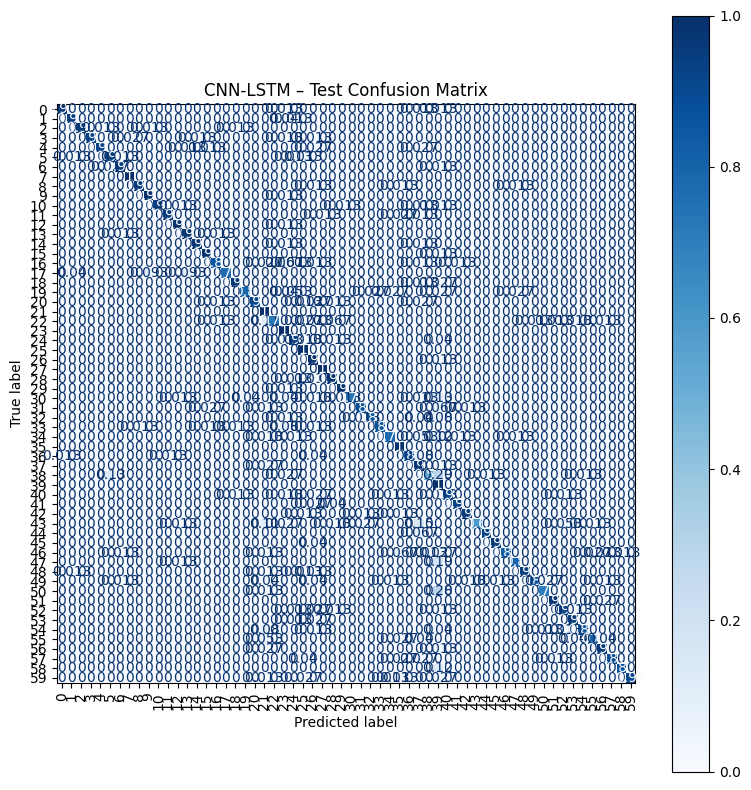

In [ ]:
plot_confusion_matrix(
    y_test_enc,
    dl_predictions["CNN-LSTM"],
    title="CNN-LSTM – Test Confusion Matrix",
    normalize="true"
)


models evaluation

ML models


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Store results here
baseline_ml_results = []

# Dictionary of baseline ML models
baseline_models = {
    "KNN (k=5)": knn5,
    "Logistic Regression": logreg,
    "Random Forest": rf,
    "SVM (RBF - Base)": svm_base
}

# Evaluate each model
for model_name, model in baseline_models.items():
    y_pred = model.predict(X_test_ml)

    acc = accuracy_score(y_test_spk, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test_spk, y_pred, average="macro", zero_division=0
    )

    baseline_ml_results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    })

# Create DataFrame
baseline_ml_df = pd.DataFrame(baseline_ml_results)

baseline_ml_df


,Model,Accuracy,Precision,Recall,F1-score
0,KNN (k=5),0.986667,0.986963,0.986667,0.986635
1,Logistic Regression,0.917556,0.918387,0.917556,0.917254
2,Random Forest,0.971333,0.971992,0.971333,0.971293
3,SVM (RBF - Base),0.990889,0.991051,0.990889,0.990898


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Store results
tuned_ml_results = []

# Dictionary of tuned ML models (EXACT notebook variable names)
tuned_models = {
    "SVM (Tuned)": best_svm,
    "KNN (Tuned)": best_knn,
    "Random Forest (Tuned)": best_rf,
    "Logistic Regression (Tuned)": best_logreg
}

# Evaluate each tuned model
for model_name, model in tuned_models.items():
    y_pred = model.predict(X_test_ml)

    acc = accuracy_score(y_test_spk, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test_spk, y_pred, average="macro", zero_division=0
    )

    tuned_ml_results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    })

# Create DataFrame
tuned_ml_df = pd.DataFrame(tuned_ml_results)

tuned_ml_df


,Model,Accuracy,Precision,Recall,F1-score
0,SVM (Tuned),0.991778,0.991932,0.991778,0.991784
1,KNN (Tuned),0.987778,0.988046,0.987778,0.987752
2,Random Forest (Tuned),0.974000,0.974591,0.974000,0.973979
3,Logistic Regression (Tuned),0.917556,0.918387,0.917556,0.917254


In [ ]:
tuned_ml_df.to_csv("tuned_ml_models_evaluation.csv", index=False)


In [ ]:
for name, m in dl_models.items():
    print(name, "->", type(m))


CNN (Baseline) -> <class 'sklearn.pipeline.Pipeline'>
CNN (Improved) -> <class 'keras.src.models.sequential.Sequential'>
CNN-LSTM -> <class 'keras.src.models.sequential.Sequential'>


In [ ]:
print("Baseline CNN :", type(baseline_cnn))
print("Improved CNN :", type(improved_cnn))
print("CNN-LSTM     :", type(cnn_lstm))


Baseline CNN : <class 'keras.src.models.sequential.Sequential'>
Improved CNN : <class 'keras.src.models.sequential.Sequential'>
CNN-LSTM     : <class 'keras.src.models.sequential.Sequential'>


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_dl_model(dl_model, X_test, y_test_enc, le):
    # Predict
    y_pred_prob = dl_model.predict(X_test, verbose=0)
    y_pred_enc = np.argmax(y_pred_prob, axis=1)

    # Decode labels
    y_true = le.inverse_transform(y_test_enc)
    y_pred = le.inverse_transform(y_pred_enc)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )

    return acc, prec, rec, f1, y_pred_enc


In [ ]:
dl_models = {
    "CNN (Baseline)": baseline_cnn,
    "CNN (Improved)": improved_cnn,
    "CNN-LSTM": cnn_lstm
}


In [ ]:
dl_results = {}
dl_predictions = {}

for model_name, dl_model in dl_models.items():
    acc, prec, rec, f1, y_pred_enc = evaluate_dl_model(
        dl_model, X_test_cnn, y_test_enc, le
    )

    dl_results[model_name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    }

    dl_predictions[model_name] = y_pred_enc

# Create DataFrame
dl_models_df = pd.DataFrame(dl_results).T
dl_models_df


,Accuracy,Precision,Recall,F1-score
CNN (Baseline),0.962000,0.963759,0.962000,0.962188
CNN (Improved),0.984889,0.985332,0.984889,0.984921
CNN-LSTM,0.903778,0.931595,0.903778,0.908281


In [ ]:
dl_models_df.to_csv("deep_learning_models_evaluation.csv")


In [ ]:
import pandas as pd

final_comparison_df = pd.DataFrame({
    "Category": ["Machine Learning", "Deep Learning"],
    "Model": ["SVM (Tuned)", "CNN (Improved)"],
    "Accuracy": [0.991778, 0.984889],
    "Precision": [0.991932, 0.985332],
    "Recall": [0.991778, 0.984889],
    "F1-score": [0.991784, 0.984921]
})

final_comparison_df


,Category,Model,Accuracy,Precision,Recall,F1-score
0,Machine Learning,SVM (Tuned),0.991778,0.991932,0.991778,0.991784
1,Deep Learning,CNN (Improved),0.984889,0.985332,0.984889,0.984921


In [ ]:
# Pick any test sample
#prediction using tuned svm
idx = 0   # change index if you want

# Predict speaker using tuned SVM
svm_pred = best_svm.predict(X_test_ml[idx:idx+1])[0]

print("True Speaker     :", y_test_spk[idx])
print("Predicted Speaker:", svm_pred)


True Speaker     : 21
Predicted Speaker: 21


In [ ]:
 #prediction using Improved CNN
import numpy as np

cnn_pred_prob = improved_cnn.predict(X_test_cnn[idx:idx+1])
cnn_pred = np.argmax(cnn_pred_prob, axis=1)
cnn_pred_label = le.inverse_transform(cnn_pred)[0]

print("CNN Predicted Speaker:", cnn_pred_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
CNN Predicted Speaker: 21


## Error Analysis

- Some speakers are confused due to similar voice characteristics.
- Since AudioMNIST contains short utterances (digits only),
  speaker variability is limited.
- MFCC features capture spectral information but may miss
  long‑term temporal patterns.
- Deep learning models benefit from larger and more diverse datasets.


Audio Input
→ MFCC Extraction
→ Feature Preprocessing
→ ML / DL Model Training
→ Evaluation
→ Speaker Prediction
